# Transformer - French to English Translation

This notebook contains an implementation of the Transformer architecture from [Attention Is All You Need (Vaswani et al. 2017)](https://arxiv.org/pdf/1706.03762.pdf). Data was obtained from http://www.manythings.org/anki/

In [1]:
from fastai.text.all import *
from einops import rearrange
from typing import Dict, List

## Create DataLoaders

In [2]:
VALID_PCT = 0.05
BATCH_SIZE = 512
MAX_TOKENS_PER_SENTENCE = 30
DATA_PATH = Path("raw-data.txt")

In [3]:
df = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["tgt", "src", "metadata"])
df = df[["src", "tgt"]]
df.head()

,src,tgt
0,Va !,Go.
1,Salut !,Hi.
2,Salut.,Hi.
3,Cours !,Run!
4,Courez !,Run!


In [4]:
# Remove Long Sentences (to conserve GPU memory during training)
df = df[df["src"].apply(lambda txt: len(txt.split()) <= MAX_TOKENS_PER_SENTENCE)]
df = df[df["tgt"].apply(lambda txt: len(txt.split()) <= MAX_TOKENS_PER_SENTENCE)]
print(f"Loaded {df.shape[0]:,} training examples")

Loaded 179,887 training examples


In [5]:
# Initialize Tokenizer
rules = [
    partial(lowercase, add_bos=True, add_eos=False),
    rm_useless_spaces,
]

src_tok = Tokenizer(WordTokenizer('fr'), rules=rules)
tgt_tok = Tokenizer(WordTokenizer('en'), rules=rules)

In [6]:
# Initialize and Setup Numericalizer
src_txts = L(df["src"].values.tolist())
tgt_txts = L(df["tgt"].values.tolist())

src_toks = src_txts.map(src_tok)
tgt_toks = tgt_txts.map(tgt_tok)

src_num = Numericalize(max_vocab=30000)
tgt_num = Numericalize(max_vocab=30000)

src_num.setup(src_toks)
tgt_num.setup(tgt_toks)

In [7]:
# Create Datasets and Dataloaders
src_tfms = [ColReader("src"), src_tok, src_num]
tgt_tfms = [ColReader("tgt"), tgt_tok, tgt_num]

splits = RandomSplitter(VALID_PCT)(df)
dsets = Datasets(df, [src_tfms, tgt_tfms], splits=splits)

dls = dsets.dataloaders(
    dl_type=SortedDL,
    before_batch=partial(pad_input, pad_fields=[0, 1]),
    bs=BATCH_SIZE,
)

dls.show_batch()

,text,text_
0,xxbos une étude a montré que presque dix pour cent des hommes étaient obèses en deux - mille - huit . c' était en augmentation en partant d' environ cinq pour cent en mille - neuf - cent - quatre - vingt .,xxbos a study found that almost 10 % of men were obese in xxunk . that was up from about 5 % in 1980 . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
1,"xxbos personne ne t' a demandé d' être d' accord , mais ne peux - tu pas , au moins , accepter qu' il y a des gens qui ont un point de vue différent du tien ? xxpad xxpad xxpad xxpad xxpad","xxbos nobody has asked you to agree , but ca n't you at least accept that there are people who hold different views from you ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"xxbos personne ne vous a demandé d' être d' accord , mais ne pouvez -vous pas , au moins , accepter qu' il y a des gens qui ont un point de vue différent du vôtre ? xxpad xxpad xxpad xxpad xxpad xxpad","xxbos nobody has asked you to agree , but ca n't you at least accept that there are people who hold different views from you ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,"xxbos qu' est l' âge ? d' abord on oublie les noms , et puis on oublie les visages , puis on oublie de remonter sa braguette , et puis on oublie de la descendre . xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos what is old age ? first you forget names , then you forget faces , then you forget to pull your zipper up , then you forget to pull it down ."
4,"xxbos mon petit-déjeuner se compose généralement de café au lait , d' un morceau de pain avec de la confiture , d' une petite banane , d' un morceau d' orange et de prunes xxunk . xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos my breakfast usually consists of coffee with milk , a piece of bread and jam , a small banana , a piece of orange and some dried plums . xxpad xxpad xxpad"
5,"xxbos et la bonne nouvelle est qu' aujourd' hui l' économie se développe à nouveau . salaire , revenus , valeurs xxunk et comptes de xxunk sont tous à la hausse . la pauvreté xxunk . xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos and the good news is that today the economy is growing again . wages , xxunk , home values and retirement accounts are all rising again . poverty is falling again ."
6,"xxbos c' était suffisamment grave qu' il ait l' habitude d' arriver en retard au travail , mais qu' il arrive soûl est un comble , et je vais devoir m' en séparer . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos it was bad enough that he usually came to work late , but coming in drunk was the last straw , and i 'm going to have to let him go ."
7,"xxbos la prochaine fois que je change d' emploi , j' ai besoin d' un travail qui me permettra de mettre à profit l' expérience que j' ai xxunk jusqu' à maintenant . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos next time i switch jobs , i need work that will let me make use of the experience i 've gained up to now . xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
8,"xxbos s' arrêter de fumer , c' est ce qu' il y a de plus facile . je le sais bien pour l' avoir fait moi - même des milliers de fois . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",xxbos giving up smoking is the easiest thing in the world . i know because i 've done it thousands of times . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad


## Define Model Architecture

In [8]:
class PositionalEncoder(nn.Module):
    """An encoder that generates embeddings for each input token. The
    embeddings generated are a combination of the tokens' regualar embeddings
    and positional embeddings."""
    
    def __init__(self, embedding_dim: int, vocab_sz: int, dropout_p: float):
        super().__init__()
        self.tok_embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(p=dropout_p)
        
        exponent = torch.arange(0, embedding_dim, 2).cuda()
        exponent = exponent / embedding_dim
        period = 10000**exponent
        period = period[None, :]
        self.register_buffer('period', period)
        
    def forward(self, x: torch.Tensor):
        seq_len = x.size(1)
        tok_embedding = self.tok_embedding(x) * math.sqrt(self.embedding_dim)
        pos_embedding = self.get_pos_embedding(seq_len)
        embedding = tok_embedding + pos_embedding
        embedding = self.dropout(embedding)
        return embedding
    
    def get_pos_embedding(self, seq_len: int):
        pos = torch.arange(seq_len)[:, None].cuda()
        sinusoid_inputs = pos / self.period
        sin = sinusoid_inputs.sin()
        cos = sinusoid_inputs.cos()
        pos_embedding = torch.stack([sin, cos]).view(2, -1).t().reshape(seq_len, -1)
        return pos_embedding

In [9]:
class FeedForwardLayer(nn.Module):
    """Position-wise feed forward layer used in both the encoder and the decoder"""
    
    def __init__(self, embedding_dim: int, hidden_dim: int, dropout_p: float):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, embedding_dim)
        self.dropout = nn.Dropout(p=dropout_p)
    
    def forward(self, x: torch.Tensor):
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [10]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention layer, used in both the encoder and decoder"""
    
    def __init__(self, embedding_dim: int, num_heads: int, dropout_p: float):
        super().__init__()
        self.num_heads = num_heads
        self.key_dim = embedding_dim // num_heads
        
        self.q_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.k_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.v_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim, bias=False)
        
        self.attn_softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, qry: torch.Tensor, key: torch.Tensor, val: torch.Tensor,
                mask: torch.Tensor = None):
        qry = self.q_proj(qry)
        key = self.k_proj(key)
        val = self.v_proj(val)
        
        qry = rearrange(qry, 'b s (h q) -> b h s q', h=self.num_heads)
        key = rearrange(key, 'b s (h k) -> b h k s', h=self.num_heads)
        val = rearrange(val, 'b s (h v) -> b h s v', h=self.num_heads)
        
        x = self.attention(qry, key, val, mask)
        x = self.out_proj(x)
        x = self.dropout(x)
        return x
        
    def attention(self, qry: torch.Tensor, key: torch.Tensor, val: torch.Tensor,
                  mask: torch.Tensor):
        x = qry@key / math.sqrt(self.key_dim)
        if mask is not None:
            x = x + mask
        x = self.attn_softmax(x)
        x = x@val
        x = rearrange(x, 'b h s v -> b s (h v)')
        return x

In [11]:
class EncoderLayer(nn.Module):
    """A single encoder layer. Many of these layers can be stacked on top of
    each other to increase the encoder's depth."""
    
    def __init__(self, embedding_dim: int, num_heads: int, hidden_dim: int, dropout_p: float):
        super().__init__()
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_p)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ff = FeedForwardLayer(embedding_dim, hidden_dim, dropout_p)
        self.ln2 = nn.LayerNorm(embedding_dim)
        
    def forward(self, x: torch.Tensor):
        x = self.ln1(x + self.mha(x, x, x))
        x = self.ln2(x + self.ff(x))
        return x

In [12]:
class DecoderLayer(nn.Module):
    """A single decoder layer. Many of these layers can be stacked on top of
    each other to increase the encoder's depth."""
    
    def __init__(self, embedding_dim: int, num_heads: int, hidden_dim: int, dropout_p: float):
        super().__init__()
        self.masked_mha = MultiHeadAttention(embedding_dim, num_heads, dropout_p)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_p)
        self.ln2 = nn.LayerNorm(embedding_dim)
        self.ff = FeedForwardLayer(embedding_dim, hidden_dim, dropout_p)
        self.ln3 = nn.LayerNorm(embedding_dim)
    
    def forward(self, inp: torch.Tensor):
        x, enc_out, mask = inp
        x = self.ln1(x + self.masked_mha(x, x, x, mask))
        x = self.ln2(x + self.mha(x, enc_out, enc_out))
        x = self.ln3(x + self.ff(x))
        return x, enc_out, mask

In [13]:
class Transformer(nn.Module):
    """The transformer architecture applied to machine translation."""
    
    def __init__(self, embedding_dim: int, src_vocab_sz: int, tgt_vocab_sz: int,
                 num_layers: int, num_heads: int, hidden_dim: int, dropout_p: float):
        super().__init__()
        self.src_embeddings = PositionalEncoder(embedding_dim, src_vocab_sz, dropout_p)
        self.tgt_embeddings = PositionalEncoder(embedding_dim, tgt_vocab_sz, dropout_p)
        
        self.encoder = nn.Sequential(*[EncoderLayer(embedding_dim, num_heads, hidden_dim, dropout_p) for _ in range(num_layers)])
        self.decoder = nn.Sequential(*[DecoderLayer(embedding_dim, num_heads, hidden_dim, dropout_p) for _ in range(num_layers)])

        self.fc_out = nn.Linear(embedding_dim, tgt_vocab_sz)
        self.fc_out.weight = self.tgt_embeddings.tok_embedding.weight
    
    def forward(self, enc_in: torch.Tensor, dec_in: torch.Tensor):
        enc_in = self.src_embeddings(enc_in)
        dec_in = self.tgt_embeddings(dec_in)
        
        enc_out = self.encoder(enc_in)
        
        out_seq_len = dec_in.size(1)
        dec_mask = torch.triu(torch.full((out_seq_len, out_seq_len), float("-Inf")), 1).cuda()
        dec_out, _, _ = self.decoder((dec_in, enc_out, dec_mask))
        dec_out = self.fc_out(dec_out)
        return dec_out

## Train Model

In [14]:
class DataPrepCallback(Callback):
    """Callback to shift outputs by one so that the model doesn't 'look ahead'
    during training. Also, supply the shifted outputs to the model as inputs."""
    def before_batch(self):
        self.learn.xb = (self.x, self.y[:, :-1])
        self.learn.yb = (self.y[:, 1:],)

In [15]:
class IncorrectTokenInjectionCallback(Callback):
    """This callback injects incorrect tokens into the decoder input during
    training. By default, transformers implicitly implement teacher forcing during
    training, since they are given the (correct) previous tokens in a sentence
    when predicting subsequent tokens, which may lead to poorer generalisation.
    This callback attempts to remedy this by making the model more robust to
    incorrectly-predicted tokens during inference."""
    
    def __init__(self, tgt_vocab_len: int, rate: float = 0.25):
        assert 0.0 <= rate <= 1.0
        self.tgt_vocab_len = tgt_vocab_len
        self.rate = rate
    
    def before_batch(self):
        enc_in, dec_in = self.xb
        incorrect_pct = np.round(self.rate * self.epoch / self.n_epoch, 1)
        rand_mask = (torch.rand(dec_in.shape) < incorrect_pct).int().cuda()
        rand_vals = torch.randint(low=8, high=self.tgt_vocab_len, size=dec_in.shape).cuda()
        dec_in = dec_in * (1 - rand_mask) + rand_vals * rand_mask
        self.learn.xb = (enc_in, dec_in)

In [16]:
def masked_accuracy(inp: torch.Tensor, targ: torch.Tensor, axis: int =-1):
    """Compute accuracy with `targ` when `pred` is bs * n_classes
    while masking out padding tokens"""
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return torch.where(targ != 1, pred == targ, False).sum() / (targ != 1).sum()

In [17]:
# Set hyperparameters and initialize model
EMBEDDING_DIM = 512
NUM_LAYERS = 6
NUM_HEADS = 8
HIDDEN_DIM = 2048
DROPOUT_P = 0.1

src_vocab_sz = len(dls.vocab[0])
tgt_vocab_sz = len(dls.vocab[1])

model = Transformer(EMBEDDING_DIM, src_vocab_sz, tgt_vocab_sz,
                    NUM_LAYERS, NUM_HEADS, HIDDEN_DIM, DROPOUT_P)

In [18]:
label_smooth_loss = LabelSmoothingCrossEntropyFlat(eps=0.1, reduction='none')

def masked_label_smooth_loss(pred: torch.Tensor, targ: torch.Tensor):
    """Mask out predictions for padding tokens so that they don't
    contribute to the loss"""
    loss = label_smooth_loss(pred, targ)
    targ = targ.reshape(-1)
    loss = torch.where(targ == 1, torch.zeros(targ.shape).float().cuda(), loss)
    return loss.sum() / (targ != 1).sum()

In [19]:
learn = Learner(
    dls, model,
    loss_func=masked_label_smooth_loss,
    cbs=[DataPrepCallback,
         IncorrectTokenInjectionCallback(tgt_vocab_sz, 0.25)],
    metrics=[masked_accuracy, CorpusBLEUMetric()],
)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=2.511886486900039e-05)

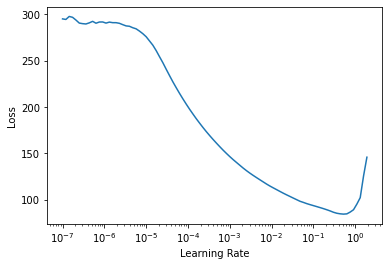

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(200, lr_max=1e-4)

epoch,train_loss,valid_loss,masked_accuracy,corpus_bleu,time
0,32.033127,25.688520,0.146299,0.092956,00:56
1,23.547646,19.835833,0.175566,0.070529,00:56
2,20.527384,17.768488,0.223209,0.062801,00:58
3,18.775843,16.582281,0.260287,0.064996,00:58
4,17.582838,15.710561,0.289660,0.060551,00:56
5,16.459263,14.837656,0.318942,0.059922,00:56
6,15.396769,13.922946,0.335019,0.062684,00:56
7,14.252024,13.015379,0.364307,0.065281,00:56
8,13.356359,12.086343,0.370678,0.069447,00:56
9,12.276947,11.170087,0.394599,0.073416,00:56


## Inspect Model Translations (Generated Using Beam Search)

In [22]:
BEAM_SIZE = 32  # Number of possible translations to consider at each point in the tree
NUM_HYPOTHESES = 16  # The maximum number of translations to generate before stopping
MAX_LENGTH = MAX_TOKENS_PER_SENTENCE  # The maximum length of any translation
NUM_EXAMPLES = 24

tgt_vocab = dls.vocab[1]
model = learn.model
xb, yb = dls.valid.one_batch()
xb = xb[:NUM_EXAMPLES]
yb = yb[:NUM_EXAMPLES]

In [23]:
class BeamSearchNode():
    """A node to be used in a beam search tree"""
    
    def __init__(self, token_idxs: torch.Tensor, sentence_pos: int, norm_cumulative_ll: float):
        self.token_idxs = token_idxs
        self.sentence_pos = sentence_pos
        self.norm_cumulative_ll = norm_cumulative_ll
    
    def create_child(self, new_token_idx: int, log_likelihood: float):
        token_idxs = torch.cat([self.token_idxs, torch.tensor([new_token_idx])])
        sentence_pos = self.sentence_pos + 1
        norm_cumulative_ll = (self.norm_cumulative_ll * self.sentence_pos + log_likelihood) / sentence_pos
        child = BeamSearchNode(token_idxs, sentence_pos, norm_cumulative_ll)
        return child

In [24]:
def num2txt(num_tensor, numericalizer, tokenizer):
    """Convert embedding indices into words"""
    txt = tokenizer.decode(numericalizer.decode(num_tensor))
    txt = txt.replace(" xxpad", "")
    return txt

In [25]:
# Perform Beam Search
period_idx = tgt_vocab.index('.')

data = []
for src, tgt in progress_bar(list(zip(xb, yb))):
    finished: List[BeamSearchNode] = []
    in_progress: List[BeamSearchNode] = []
    
    src_period_count = src.detach().cpu().numpy().tolist().count(period_idx)
    root_idxs = torch.tensor([tgt_vocab.index("xxbos")])
    root = BeamSearchNode(token_idxs=root_idxs, sentence_pos=0, norm_cumulative_ll=0.0)
    in_progress.append(root)
    
    while len(finished) < NUM_HYPOTHESES:
        # Take the node with the highest log-likelihood and generate its child nodes
        in_progress.sort(key=lambda node: node.norm_cumulative_ll, reverse=True)
        node = in_progress.pop(0)

        enc_in = src[None]
        dec_in = node.token_idxs[None].to(dls.device)

        out = model(enc_in, dec_in)[0][-1].softmax(0)
        token_idxs = out.argsort(descending=True)[:BEAM_SIZE]
        token_idxs = token_idxs.cpu().numpy().tolist()

        for token_idx in token_idxs:
            log_likelihood = out[token_idx].log()
            child = node.create_child(token_idx, log_likelihood)
            
            is_max_len = child.sentence_pos >= MAX_LENGTH
            is_eos_tok = tgt_vocab[token_idx] in ["xxeos"]
            pred_period_count = child.token_idxs.numpy().tolist().count(period_idx)
            same_period_count = (pred_period_count == src_period_count)
            if is_max_len or is_eos_tok or same_period_count:
                finished.append(child)
            else:
                in_progress.append(child)

    finished.sort(key=lambda node: node.norm_cumulative_ll, reverse=True)
    best_translation = finished[0]
    pred_words = num2txt(best_translation.token_idxs[1:], tgt_num, tgt_tok)
    norm_ll = round(best_translation.norm_cumulative_ll.item(), 4)

    src_words = num2txt(src[1:], src_num, src_tok)
    tgt_words = num2txt(tgt[1:], tgt_num, tgt_tok)

    data.append({
        "source": src_words,
        "target": tgt_words,
        "prediction": pred_words,
        "norm_ll": norm_ll,
    })

valid_df = pd.DataFrame(data).sort_values("norm_ll", ascending=False)
valid_df

,source,target,prediction,norm_ll
7,"la première fois que vous rencontrez une personne , vous devriez être attentive à la proximité avec laquelle vous vous tenez par rapport à elle .","the first time you meet people , you should be careful about how near you stand to them .","the first time you meet people , you should be careful about how near you stand to them .",-0.0634
2,"conformément aux closes du contrat , vous pouvez prendre trois jours de congé de deuil pour les funérailles de votre oncle , mais un seul pour celles de votre neveu .","according to the contract you may take three days of bereavement leave for your uncle 's funeral , but only one for your nephew 's .","according to the contract you may take three days of bereavement leave for your uncle 's funeral , but only one for your nephew 's funeral .",-0.1337
19,je n' ai jamais imaginé un seul instant que je serais toujours en train de faire ce genre de chose à mon âge .,i never for a moment imagined that i would still be doing this kind of thing at my age .,i never for a moment imagined that i 'd be doing this kind of thing at my age .,-0.1529
21,ne prenez pas la peine de me réveiller à quatre heures du matin . je ne prévois pas d' aller pêcher demain .,do n't bother waking me up at 4:00 a.m. i do n't plan to go fishing tomorrow .,do n't bother waking me up at 4:00 a.m. i do n't plan to go fishing tomorrow . i do n't plan to go fishing tomorrow .,-0.1733
23,il n' y a rien de plus embêtant qu' un groupe de jeunes filles qui essayent toutes de parler en même temps .,there 's nothing more annoying than a group of young girls all trying to talk at the same time .,there 's nothing more annoying than a group of young girls all trying to talk at the same time .,-0.1912
9,"elle lui a recommandé de prendre de longues vacances , il a donc quitté immédiatement le travail et est parti en voyage autour du monde .","she advised him to take a long holiday , so he immediately quit work and took a trip around the world .","she advised him to take a long holiday , so he left work and took a trip around the world .",-0.2086
0,"ce qu' est l' âge ? d' abord on oublie les noms , et puis on oublie les visages , puis on oublie de remonter sa braguette , et puis on oublie de la descendre .","what is old age ? first you forget names , then you forget faces , then you forget to pull your zipper up , then you forget to pull it down .","what is old age ? first you forget to pull your age , then you forget to pull it down , then you forget to pull it down .",-0.2311
6,"si j' en parle à ma mère , elle va se faire du souci , donc je ne pense pas que je lui en parlerai .","if i tell my mother , she 'll worry , so i do n't think i 'll tell her .","she is talking to me , so i think about it , so i do n't think about it .",-0.3486
15,« pourquoi vas - tu au japon ? » « pour participer à une conférence à tokyo . »,"why are you going to japan ? "" to attend a conference in tokyo . ""","why are you going to come to japan ? "" in tokyo with a conference .",-0.4561
3,"plus l' on passe de temps à parler une langue étrangère , plus l' on s' améliore à devenir ce qu' un xxunk essaie de dire dans sa propre langue .","the more time you spend speaking a foreign language , the better you get at guessing what non - native speakers are trying to say in your own language .","in what is trying to become a foreign language , you try to become more than one language you get to become a foreign language .",-0.5408
